In [1]:
from pytorch_transformers import GPT2Tokenizer
from experiment import Intervention, Model
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import torch

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = Model(output_attentions=True)

In [3]:
def perform_intervention(intervention):
	
	candidate1_base_prob, candidate2_base_prob, candidate1_alt_prob, candidate2_alt_prob, candidate1_probs, candidate2_probs = model.attention_intervention_experiment(intervention)
	
	candidate1 = intervention.candidates[0][1:]
	candidate2 = intervention.candidates[1][1:]
	
	odds_base = candidate2_base_prob / candidate1_base_prob
	odds_intervention = candidate2_probs / candidate1_probs
	odds_ratio = odds_intervention / odds_base
	
	print("Intervention: replace Attn(x) with Attn(x') in a specific layer/head")
	print(f"x : {intervention.base_strings[0]}")
	print(f"x': {intervention.base_strings[1]}")
	print("Input value: x")
	print(f"Continuations compared: {candidate1} / {candidate2}")
	print(f"p({candidate1}|x): {candidate1_base_prob * 100:.2f}% p({candidate2}|x): {candidate2_base_prob * 100:.2f}%")
	print(f"p({candidate1}|x'): {candidate1_alt_prob * 100:.2f}% p({candidate2}|x'): {candidate2_alt_prob * 100:.2f}%")
	print()
	print(f'Odds ratio (p("{candidate2}"|Attn(x\')) / p("{candidate1}"|Attn(x\')) / (p("{candidate2}") / p("{candidate1}")):')
	
	plt.figure(figsize=(9,7)) 
	ax = sns.heatmap(odds_ratio, annot=True, annot_kws={"size": 12}, fmt=".2f")
	# ax.set_title("Attention Intervention Odds Ratio")
	ax.set(xlabel='Head', ylabel='Layer')

100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
Input value: x
Continuations compared: asked / answered
p(asked|x): 18.92% p(answered|x): 1.16%
p(asked|x'): 10.31% p(answered|x'): 3.84%

Odds ratio (p("answered"|Attn(x')) / p("asked"|Attn(x')) / (p("answered") / p("asked")):


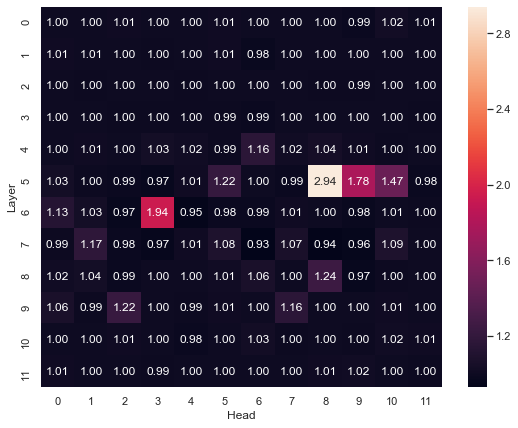

In [4]:
# Test experiment
intervention1 = Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["asked", "answered"])
perform_intervention(intervention1)

100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
Input value: x
Continuations compared: requested / responded
p(requested|x): 0.07% p(responded|x): 0.37%
p(requested|x'): 0.04% p(responded|x'): 1.86%

Odds ratio (p("responded"|Attn(x')) / p("requested"|Attn(x')) / (p("responded") / p("requested")):


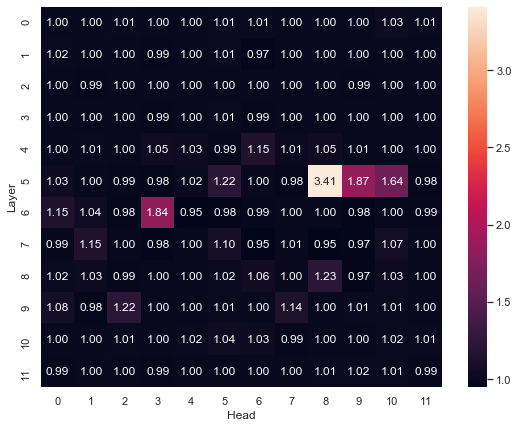

In [5]:
intervention2 = Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["requested", "responded"])
perform_intervention(intervention2)

100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The man felt sorry about what he said to the woman. He
x': The man felt sorry about what he said to the woman. She
Input value: x
Continuations compared: apologized / forgave
p(apologized|x): 1.05% p(forgave|x): 0.00%
p(apologized|x'): 0.42% p(forgave|x'): 0.00%

Odds ratio (p("forgave"|Attn(x')) / p("apologized"|Attn(x')) / (p("forgave") / p("apologized")):


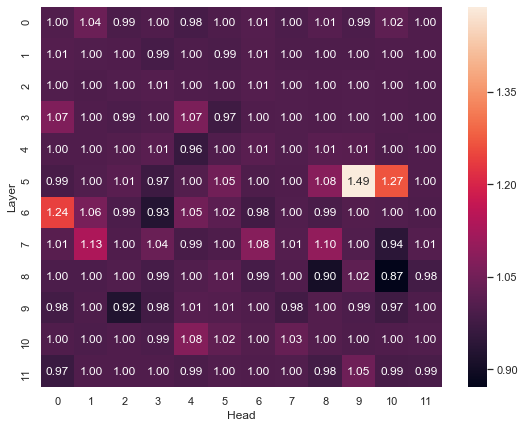

In [6]:
intervention3 = Intervention(
        tokenizer,
        "The man felt sorry about what he said to the woman. {}",
        ["He", "She"],
        ["apologized", "forgave"])
perform_intervention(intervention3)

100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Intervention: replace Attn(x) with Attn(x') in a specific layer/head
x : The nurse notified the patient that her
x': The nurse notified the patient that his
Input value: x
Continuations compared: shift / blood
p(shift|x): 0.06% p(blood|x): 2.55%
p(shift|x'): 0.03% p(blood|x'): 3.16%

Odds ratio (p("blood"|Attn(x')) / p("shift"|Attn(x')) / (p("blood") / p("shift")):


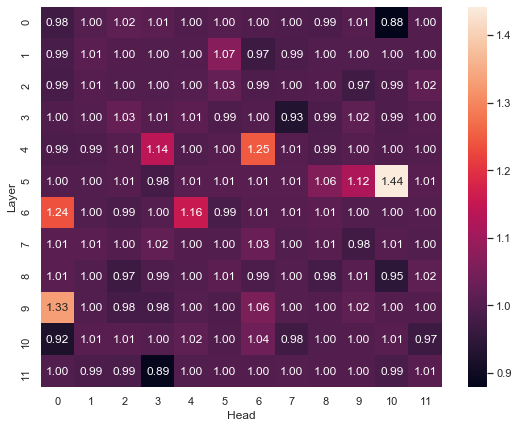

In [7]:
intervention4 = Intervention(
        tokenizer,
        "The nurse notified the patient that {}",
        ["her", "his"],
        ["shift", "blood"])
perform_intervention(intervention4)

In [8]:
def perform_interventions(interventions):
	
	log_odds_ratio_sum = torch.zeros((model.num_layers, model.num_heads))
	log_odds_ratio_count = 0
	for intervention in interventions:
		candidate1_base_prob, candidate2_base_prob, candidate1_alt_prob, candidate2_alt_prob, candidate1_probs, candidate2_probs = model.attention_intervention_experiment(intervention)		
		log_odds_base = torch.log(candidate2_base_prob) - torch.log(candidate1_base_prob)
		log_odds_intervention = torch.log(candidate2_probs) - torch.log(candidate1_probs)
		log_odds_ratio = log_odds_intervention - log_odds_base
		log_odds_ratio_sum += log_odds_ratio
		log_odds_ratio_count += 1
		
	print("Intervention: replace Attn(x) with Attn(x') in a specific layer/head")
	print(f"Num interventions: {log_odds_ratio_count}")
	print("Mean log odds:")
	plt.figure(figsize=(9,7)) 
	ax = sns.heatmap(log_odds_ratio_sum / log_odds_ratio_count, annot=True, annot_kws={"size": 12}, fmt=".2f")
	ax.set(xlabel='Head', ylabel='Layer')

100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Intervention: replace Attn(x) with Attn(x') in a specific layer/head
Num interventions: 4
Mean log odds:


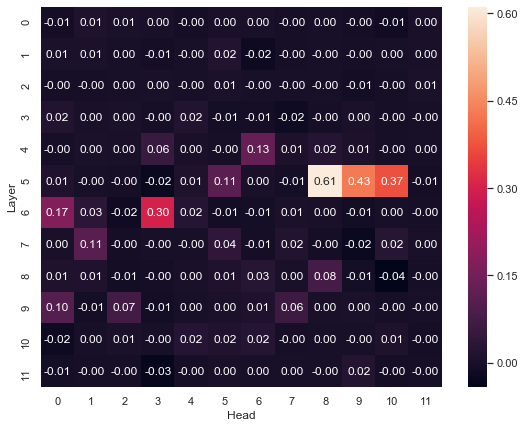

In [9]:
perform_interventions([intervention1, intervention2, intervention3, intervention4])

